<a href="https://colab.research.google.com/github/Chitolina/DataScience/blob/main/Forecast2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score


!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
weeks = pd.read_csv("weeks.csv")
weeks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_purchase_timestamp  86 non-null     object 
 1   price                     86 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [ ]:
weeks.head()

,order_purchase_timestamp,price
0,2017-01-08,5658.96
1,2017-01-15,11108.57
2,2017-01-22,23746.94
3,2017-01-29,55237.80
4,2017-02-05,65637.89


In [ ]:
weeks['order_purchase_timestamp'] = pd.to_datetime(weeks['order_purchase_timestamp'])
weeks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_purchase_timestamp  86 non-null     datetime64[ns]
 1   price                     86 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


## Estacionaridade

* Estacionária: propriedades estatísticas CONSTANTES; ✔
* Não estacionária: propriedades estatísticas MUDAM. ❌

### Por que checar a estacionaridade?

Uma série estacionária tem média constante durante o tempo, não existe tendências de alta ou de baixa. A razão disso é que tendo uma **média constante** com variações ao redor desta média **fica muito mais fácil de extrapolar ao futuro.**

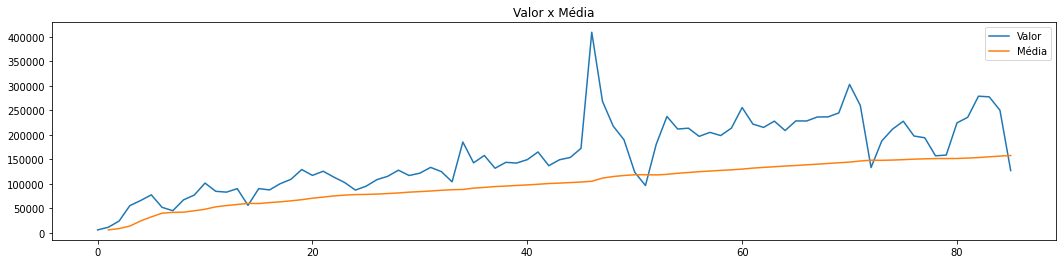

In [ ]:
#Criando uma média que se expande do primeiro valor e acumulado até cada dia anterior

mean = [np.mean(weeks["price"][:x]) for x in range(len(weeks["price"]))]
plt.figure(figsize=(18,4))
plt.plot(weeks["price"], label='Valor')
plt.plot(mean, label='Média')
plt.title('Valor x Média')
plt.legend()
plt.show()

## **Análise de Autocorrelação**

Quando o assunto é Autocorrelação, significa que existe uma correlação de determinados períodos anteriores com o período atual, o nome que se dá ao período com esta correlação é lag, exemplo: em uma série que tem medições a cada hora, a temperatura de hoje às 12:00h é muito semelhante à temperatura de 24 horas atrás, neste caso há uma auto correlação dos valores atuais com o 24º lag.
  

**Existir auto correlação é condição para se criar previsões** com uma única variável, pois caso não exista essa correlação não pode-se usar valores passados para prever o futuro.



/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


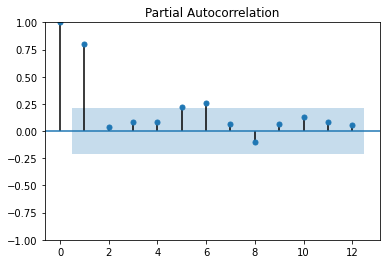

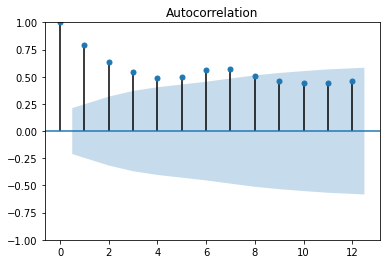

In [ ]:
plot_pacf(weeks.price, lags=12)
plt.show()

plot_acf(weeks.price, lags=12)
plt.show()

>**Autocorrelações próximas de zero: Aleatória**

>**Quedas e picos positivos: Tendência ou Sazonalidade**

In [ ]:
weeks.set_index(weeks['order_purchase_timestamp'], inplace=True)
weeks= weeks.drop(columns=['order_purchase_timestamp'])
weeks.head()

,price
order_purchase_timestamp,
2017-01-08,5658.96
2017-01-15,11108.57
2017-01-22,23746.94
2017-01-29,55237.80
2017-02-05,65637.89


## Testes estatísticos para confirmar se a séries é estacionária:
* teste de Dickey Fuller.

In [ ]:
#Teste de Dickey Fuller
adfinput = adfuller(train['price'])
adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Valores Críticos (%s)"%key] = value.round(4) 
adftest

Teste Estatistico Dickey Fuller    -2.9086
Valor-P                             0.0444
Lags Usados                         0.0000
Número de observações usadas       59.0000
Valores Críticos (1%)              -3.5464
Valores Críticos (5%)              -2.9119
Valores Críticos (10%)             -2.5937
dtype: float64

* Caso o **valor P** esteja abaixo do **Valor Crítico (5%)** significa que a série é estatisticamente estacionária.
* Caso o Valor crítico seja menor < que o Teste estatístico tbm indica que a serie é não estacionária

Resultado: Nâo estacionária.

### Este resultado indica que os dados não são estacionários, então precisamos usar o conceito “Integrated (I)” (parâmetro d) do modelo ARIMA para tornar os dados estacionários durante a construção do modelo.

>

### Em seguida, divido o conjunto de dados em conjuntos de treinamento e teste (70%/30%) para criar o modelo Auto ARIMA no conjunto de treinamento e prever usando o conjunto de dados de teste.

In [ ]:
weeks.reset_index('order_purchase_timestamp', inplace=True) # tirando o índice

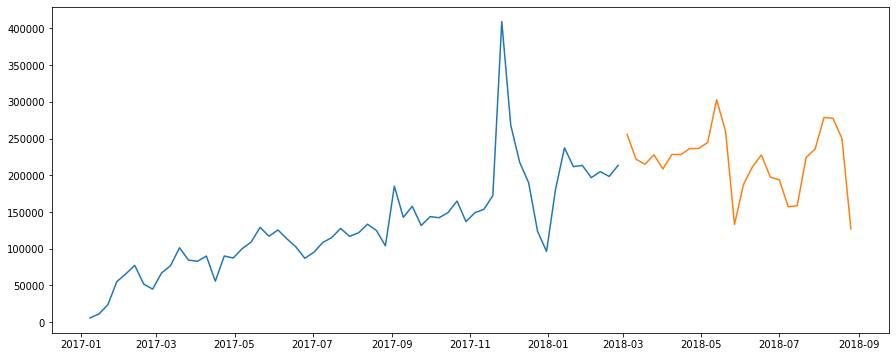

In [ ]:
train=weeks[:60] #70%
test=weeks[-26:] #30%

plt.figure(figsize=(15, 6))
plt.plot(train)
plt.plot(test)

## ARIMA, que significa Média Móvel Integrada Autoregressiva.

Modelos ARIMA são denotados com a notação ARIMA (p, d, q). Esses três parâmetros são responsáveis pela sazonalidade, tendência e ruído nos dados.

A decomposição de séries tem 3 componentes diferentes:

* **Sazonalidade :** **Padrões repetidos ocorrem em um período fixo** e conhecido no conjunto de dados.

* **Tendência :** inclui **direção** crescente ou decrescente persistente nos dados.

* **Residual:** termos após os componentes sazonais e de tendência de uma série temporal terem sido estimados e removidos. Dados que formam **flutuações de curto prazo na série que não são sistemáticas nem previsíveis.**

In [ ]:
model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

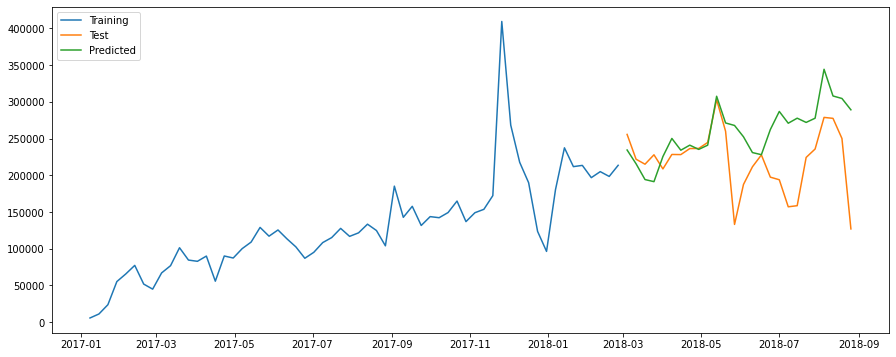

In [ ]:
prediction = pd.DataFrame(model.predict(n_periods = 26),index=test.index)
prediction.columns = ['predicted_price']
plt.figure(figsize=(15, 6))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -572.186
Date:                              Mon, 21 Mar 2022   AIC                           1152.371
Time:                                      17:47:22   BIC                           1159.772
Sample:                                           0   HQIC                          1155.156
                                               - 60                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5435      0.679     -0.801      0.423      -1.874       0.787
ma.L2         -0.3756      0.473     -0.794      0.427      -1.303       0.552
ma.S.L12      -0.6470      0.130     -4.959      0.000      -0.903      -0.391
sigma2      3.284e+09    4.9e-11   6.71e+19      0.000    3.28e+09    3.28e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               336.49
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              14.34   Skew:                             2.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+35. Standard errors may be unstable.
"""

### Modelo Preditivo: Prophet

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving series.csv to series.csv


In [ ]:
from sklearn import metrics
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

# pip install fbprophet

In [ ]:
days = pd.read_csv("days.csv", index_col=False)
days

,order_purchase_timestamp,price
0,2017-01-05,396.90
1,2017-01-06,3460.38
2,2017-01-07,1351.90
3,2017-01-08,449.78
4,2017-01-09,673.79
...,...,...
596,2018-08-24,10172.41
597,2018-08-25,10711.93
598,2018-08-26,8235.71
599,2018-08-27,5343.67


In [ ]:
days.reset_index(inplace=True)

In [ ]:
days.rename(columns={'order_purchase_timestamp':'ds','price':'y'},inplace=True)

In [ ]:
days.tail()

,ds,y
596,2018-08-24,10172.41
597,2018-08-25,10711.93
598,2018-08-26,8235.71
599,2018-08-27,5343.67
600,2018-08-28,3757.51


Treinando o Modelo

In [ ]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)
model = m.fit(days)         

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Previsão

In [ ]:
future = m.make_future_dataframe(periods=100, freq='D')
forecast = m.predict(future)
forecast.head()

In [ ]:
forecast.tail()

In [ ]:
forecast[["ds","yhat"]]

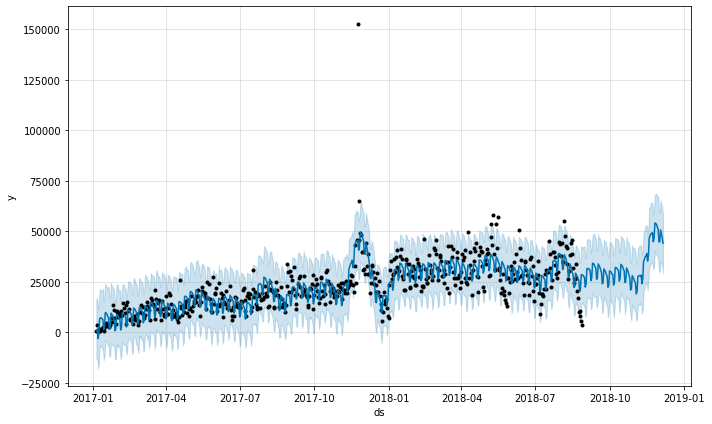

In [ ]:
plot1 = m.plot(forecast)

# Pontos: dado original
# Linha: Previsão do modelo
# Sombra: limite de variação da previsão

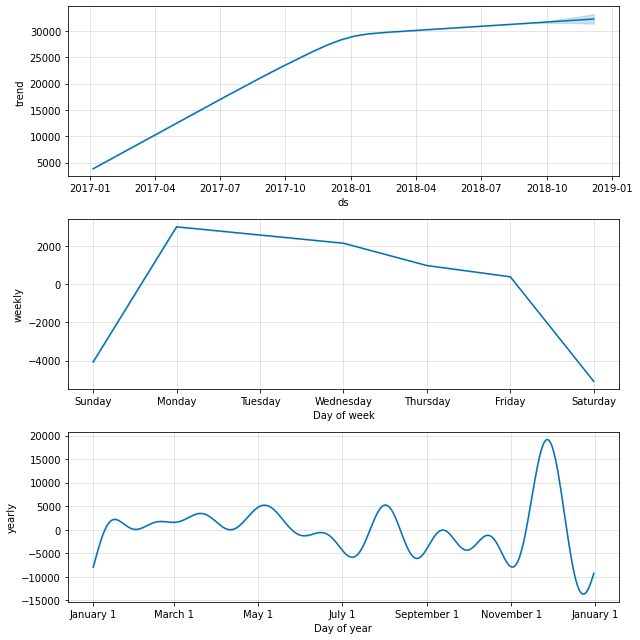

In [ ]:
plot2 = m.plot_components(forecast)